In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from PIL import Image
import numpy as np
import utils
import matplotlib.pyplot as plt

In [22]:
import simm

In [23]:
args = {}
args["data_dir"] = "data/autoencoder_img"
args["data"] = "anamoly"
args["lr"] = 0.001

In [24]:
dataloaders, dataset_sizes = utils.get_dataloaders(
            args["data"], args["data_dir"], ["test"], batch_size=1
        )

In [25]:
import timm
import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, op_channels=4, encoder_name='resnet18.a1_in1k'):
        super(UNet, self).__init__()
        self.encoder = timm.create_model(encoder_name, pretrained=True, features_only=True, out_indices=[4])

        if encoder_name.split(".")[0] == "resnet50":
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1, output_padding=0),
                nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, output_padding=0),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, output_padding=0),
                nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=0),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
                nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, op_channels, kernel_size=3, stride=2, padding=1),
                nn.Sigmoid()
            )
        if encoder_name.split(".")[0] == "resnet18":
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(512, 256, kernel_size=4, stride=3, padding=1),
                nn.ConvTranspose2d(256, 128, kernel_size=4, stride=3, padding=1),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(128, 64, kernel_size=4, stride=3, padding=1),
                nn.ConvTranspose2d(64, 32, kernel_size=4, stride=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
                nn.Conv2d(32, op_channels, kernel_size=3, padding=1),
                nn.Sigmoid()
            )
        # self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

    def forward(self, x):
        encoder_features = []
        encoder_features = self.encoder(x)
        x = encoder_features[-1].clone()
        # x = F.interpolate(x, size=(8, 8), mode='nearest')
        x = self.decoder(x)
        return x, encoder_features[-1]

In [41]:
import timm
import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, op_channels=4, encoder_name='resnet18.a1_in1k'):
        super(UNet, self).__init__()
        self.encoder = timm.create_model(encoder_name, pretrained=True, features_only=True, out_indices=[4])

        if encoder_name.split(".")[0] == "resnet50":
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1, output_padding=0),
                nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, output_padding=0),
                nn.ReLU(inplace=True),
                nn.Dropout2d(0.5),
                nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, output_padding=0),
                nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=0),
                nn.ReLU(inplace=True),
                nn.Dropout2d(0.5),
                nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
                nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
                nn.ReLU(inplace=True),
                nn.Dropout2d(0.5),
                nn.Conv2d(32, op_channels, kernel_size=3, stride=2, padding=1),
                nn.Sigmoid()
            )
        if encoder_name.split(".")[0] == "resnet18":
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(512, 256, kernel_size=4, stride=3, padding=1),
                nn.ConvTranspose2d(256, 128, kernel_size=4, stride=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout2d(0.5),
                nn.ConvTranspose2d(128, 64, kernel_size=4, stride=3, padding=1),
                nn.ConvTranspose2d(64, 32, kernel_size=4, stride=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout2d(0.5),
                nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
                nn.Conv2d(32, op_channels, kernel_size=3, padding=1),
                nn.Sigmoid()
            )
        # self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

    def forward(self, x):
        encoder_features = []
        encoder_features = self.encoder(x)
        x = encoder_features[-1].clone()
        # x = F.interpolate(x, size=(8, 8), mode='nearest')
        x = self.decoder(x)
        return x, encoder_features[-1]

In [42]:
def get_device(device_str):
    if device_str == "gpu" and torch.cuda.is_available():
        return torch.device("cuda")
    elif device_str == "cpu":
        return torch.device("cpu")
    elif device_str == "mps" and torch.backends.mps.is_available():
        return torch.device("mps")  # You can modify the GPU index if needed
    else:
        print("Warning: Invalid device option. Using CPU.")
        return torch.device("cpu")
device = get_device("mps")

In [43]:
model = UNet(op_channels=1, encoder_name="resnet50.a1_in1k")
model.load_state_dict(torch.load("models/reconstructor-dropout.pth"))
# model.load_state_dict(torch.load("models/reconstructor.pth"))
loss_fn = simm.SSIMLoss()
loss_fn = nn.MSELoss()
model = model.to(device)

In [44]:
def image_to_arrag(image):
    return image.permute(1, 2, 0).cpu().detach().numpy().astype("float")

In [33]:
images, masks, cls = next(iter(dataloaders["test"]))
print(images.shape, masks.shape)

torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


In [45]:
from tqdm import tqdm

In [46]:
def test_model(model, loss_fn, dataloader, dataset_size):
    model.eval()
    test_loss = 0.0
    all_outputs = []
    all_targets = []
    all_inputs = []
    all_types = []
    all_losses = []
    all_embeddings = []
    with torch.no_grad():
        for inputs, labels, typ in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, emb = model(inputs.repeat(1,3,1,1))
            all_embeddings.append(emb)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            all_outputs.append(outputs.cpu())
            all_types.append(typ[0])
            all_targets.append(labels.cpu())
            all_inputs.append(inputs.cpu())
            all_losses.append(loss.item())
    test_loss = test_loss / dataset_size
    all_inputs, all_embeddings, all_outputs, all_targets = torch.cat(all_inputs), torch.cat(all_embeddings), torch.cat(all_outputs), torch.cat(all_targets)
    print(f"Test Loss: {test_loss:.4f}")
    return all_inputs, all_embeddings, all_outputs, all_targets, all_types, all_losses
inputs, embeddings, outputs, targets, types, losses = test_model(model, loss_fn, dataloaders["test"], dataset_sizes["test"])

Test Loss: 0.0045


In [10]:
del model

Text(0.5, 1.0, 'Scatter Plot of Individual Losses')

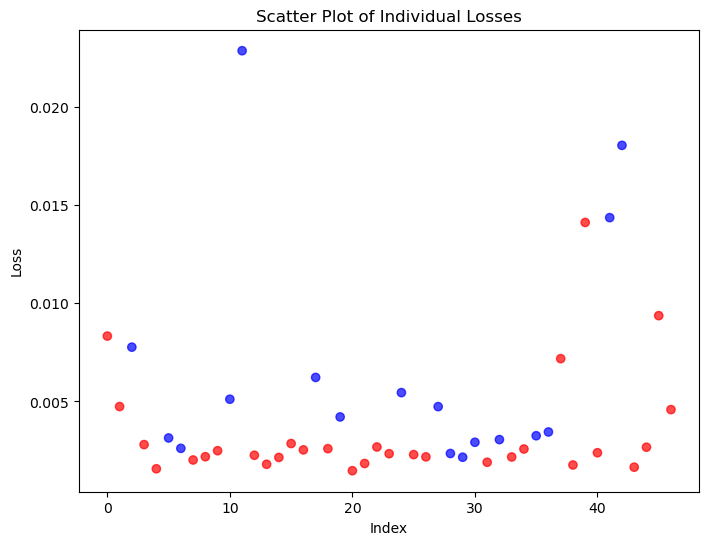

In [47]:
plt.figure(figsize=(8, 6))
colors = {'normal': 'red', 'abnormal': 'blue'}
colors_list = [colors[val] for val in types]
plt.scatter(range(dataset_sizes["test"]), losses, color=colors_list, alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Loss')
plt.title('Scatter Plot of Individual Losses')

Text(0.5, 1.0, 'Boxplot of Losses')

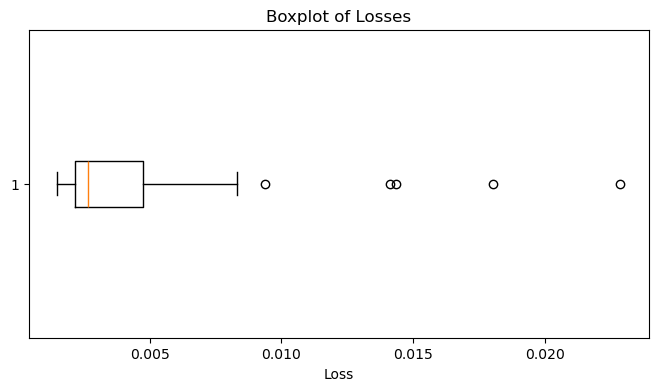

In [48]:
# Create a boxplot
plt.figure(figsize=(8, 4))
plt.boxplot(losses, vert=False)  # vert=False to display horizontally
plt.xlabel('Loss')
plt.title('Boxplot of Losses')

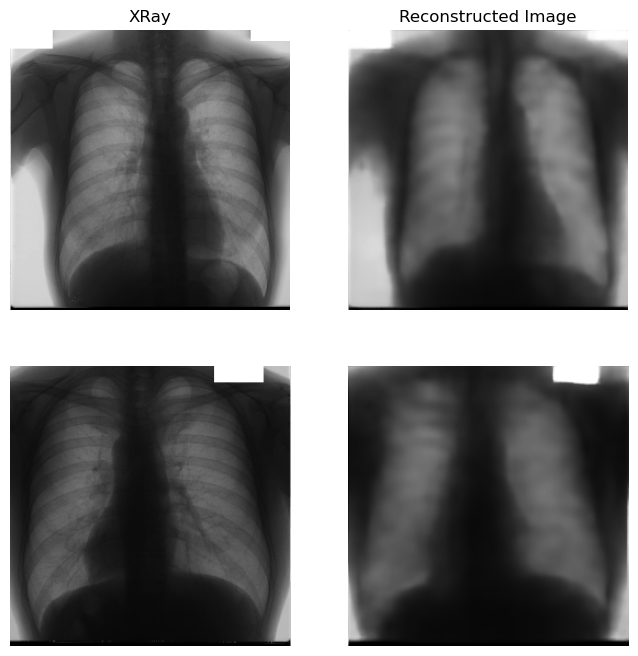

In [16]:
def plot_result(ips, outputs):
    fig = plt.figure(figsize=(8,8))
    fig.add_subplot(221)
    plt.imshow(image_to_arrag(ips[0]), cmap="gray")
    plt.title("XRay")
    plt.axis('off')
    fig.add_subplot(222)
    plt.imshow(image_to_arrag(outputs[0]), cmap="gray")
    plt.title("Reconstructed Image")
    plt.axis('off')
    fig.add_subplot(223)
    plt.imshow(image_to_arrag(ips[1]), cmap="gray")
    plt.axis('off')
    fig.add_subplot(224)
    plt.imshow(image_to_arrag(outputs[1]), cmap="gray")
    plt.axis('off')
    plt.show()
idx=4
plot_result(inputs[idx:idx+2], outputs[idx:idx+2])

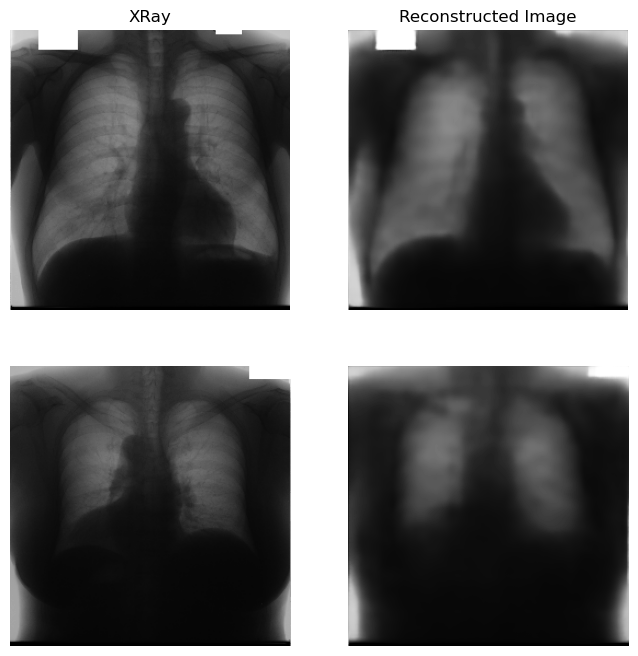

In [17]:
def plot_result(ips, outputs):
    fig = plt.figure(figsize=(8,8))
    fig.add_subplot(221)
    plt.imshow(image_to_arrag(ips[0]), cmap="gray")
    plt.title("XRay")
    plt.axis('off')
    fig.add_subplot(222)
    plt.imshow(image_to_arrag(outputs[0]), cmap="gray")
    plt.title("Reconstructed Image")
    plt.axis('off')
    fig.add_subplot(223)
    plt.imshow(image_to_arrag(ips[1]), cmap="gray")
    plt.axis('off')
    fig.add_subplot(224)
    plt.imshow(image_to_arrag(outputs[1]), cmap="gray")
    plt.axis('off')
    plt.show()
idx=6
plot_result(inputs[idx:idx+2], outputs[idx:idx+2])

In [50]:
mapping = {'normal': 1, 'abnormal': 0}
org_cluster = np.array([mapping[value] for value in types])
org_cluster

array([1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1])

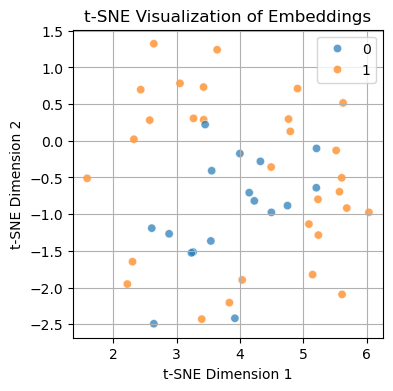

In [51]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tsne(embeddings, cluster_classes):
    # Reduce dimensionality of embeddings using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_tsne = tsne.fit_transform(embeddings)

    # Convert cluster classes to integers
    cluster_classes = cluster_classes.astype(int)

    # Plot t-SNE graph with seaborn
    plt.figure(figsize=(4,4))
    sns.scatterplot(x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1], hue=cluster_classes,
                    palette='tab10', legend='full', alpha=0.7)
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    plt.show()

plot_tsne(embeddings.view(embeddings.shape[0], -1).cpu(), org_cluster)



In [52]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score


def get_clusters_kmeans(embeddings, losses, org_cluster):
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(embeddings)
    ari = adjusted_rand_score(org_cluster, kmeans.labels_)
    print("Adjusted Rand Index (Embeddings):", ari)

    kmeans = KMeans(n_clusters=2)
    kmeans.fit(losses)
    ari = adjusted_rand_score(org_cluster, kmeans.labels_)
    print("Adjusted Rand Index (Reconstruction Loss):", ari)

get_clusters_kmeans(embeddings.view(embeddings.shape[0], -1).cpu(),
             np.array(losses).reshape(-1,1),
             org_cluster)

/Users/rishitoshsingh/miniconda3/envs/dl-asign/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index (Embeddings): -0.024538992479653857
Adjusted Rand Index (Reconstruction Loss): 0.07640058241159697


/Users/rishitoshsingh/miniconda3/envs/dl-asign/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [54]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

def get_clusters_dbscan(embeddings, losses, org_cluster):
    print("Embeddings:")
    dbscan = DBSCAN(eps=0.2, min_samples=20)
    dbscan.fit(embeddings)
    n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
    print("Number of clusters: ", n_clusters_)
    ari = adjusted_rand_score(org_cluster, dbscan.labels_)
    print("Adjusted Rand Index:", ari)

    dbscan = DBSCAN(eps=0.3, min_samples=10)
    dbscan.fit(losses)
    n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
    print("Number of clusters: ", n_clusters_)
    ari = adjusted_rand_score(org_cluster, dbscan.labels_)
    print("Adjusted Rand Index:", ari)

get_clusters_dbscan(embeddings.view(embeddings.shape[0], -1).cpu(),
             np.array(losses).reshape(-1,1),
             org_cluster)

Embeddings:
Number of clusters:  0
Adjusted Rand Index: 0.0
Number of clusters:  1
Adjusted Rand Index: 0.0


In [16]:
from sklearn.mixture import GaussianMixture

def get_clusters_gm(embeddings, losses, org_cluster):
    print("Embeddings:")
    gmm = GaussianMixture(n_components=2)
    gmm.fit(embeddings)
    cluster_labels = gmm.predict(embeddings)
    ari = adjusted_rand_score(org_cluster, cluster_labels)
    print("Adjusted Rand Index:", ari)

    gmm = GaussianMixture(n_components=2)
    gmm.fit(losses)
    cluster_labels = gmm.predict(embeddings)
    ari = adjusted_rand_score(org_cluster, cluster_labels)
    print("Adjusted Rand Index:", ari)

get_clusters_gm(embeddings.view(embeddings.shape[0], -1).cpu(),
             np.array(losses).reshape(-1,1),
             org_cluster)

: 